<a href="https://colab.research.google.com/github/twoise/Pytorch-YOLOv3/blob/main/Tanawin_st123975_yolov3_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# import os

# # Set Kaggle API credentials as environment variables
# os.environ['KAGGLE_USERNAME'] = 'kmutnb'
# os.environ['KAGGLE_KEY'] = '2e8f3eec48ac90959791a330f9109431'

# import kaggle

In [3]:
# # Authenticate with Kaggle API
# kaggle.api.authenticate()

In [4]:
# !kaggle datasets download -d awsaf49/coco-2017-dataset

In [5]:
# !unzip /content/coco-2017-dataset.zip

In [6]:
!nvidia-smi

Tue Nov  7 08:16:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/darknet.py
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/util.py

--2023-11-07 08:16:22--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/darknet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11533 (11K) [text/plain]
Saving to: ‘darknet.py.1’

darknet.py.1        100%[===================>]  11.26K  --.-KB/s    in 0s      

2023-11-07 08:16:22 (87.8 MB/s) - ‘darknet.py.1’ saved [11533/11533]

--2023-11-07 08:16:22--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [8]:
!mkdir -p cfg
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/cfg/yolov3.cfg
!mv yolov3.cfg cfg/yolov3.cfg

--2023-11-07 08:16:22--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8346 (8.2K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2023-11-07 08:16:23 (109 MB/s) - ‘yolov3.cfg’ saved [8346/8346]



In [9]:
!apt install libgl1-mesa-glx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [10]:
import darknet

blocks = darknet.parse_cfg("cfg/yolov3.cfg")
print(darknet.create_modules(blocks))

({'type': 'net', 'batch': '1', 'subdivisions': '1', 'width': '416', 'height': '416', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}, ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [11]:
from util import *

class MyDarknet(nn.Module):
    def __init__(self, cfgfile):
        super(MyDarknet, self).__init__()
        # load the config file and create our model
        self.blocks = darknet.parse_cfg(cfgfile)
        self.net_info, self.module_list = darknet.create_modules(self.blocks)

    def forward(self, x, CUDA:bool):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer

        write = 0
        # run forward propagation. Follow the instruction from dictionary modules
        for i, module in enumerate(modules):
            module_type = (module["type"])

            if module_type == "convolutional" or module_type == "upsample":
                # do convolutional network
                x = self.module_list[i](x)

            elif module_type == "route":
                # concat layers
                layers = module["layers"]
                layers = [int(a) for a in layers]

                if (layers[0]) > 0:
                    layers[0] = layers[0] - i

                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i

                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)


            elif  module_type == "shortcut":
                from_ = int(module["from"])
                # residual network
                x = outputs[i-1] + outputs[i+from_]

            elif module_type == 'yolo':
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])

                #Get the number of classes
                num_classes = int (module["classes"])

                #Transform
                # predict_transform is in util.py
                batch_size = x.size(0)
                stride =  inp_dim // x.size(2)
                grid_size = inp_dim // stride
                bbox_attrs = 5 + num_classes
                num_anchors = len(anchors)

                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:              #if no collector has been intialised.
                    detections = x
                    write = 1

                else:
                    detections = torch.cat((detections, x), 1)

            outputs[i] = x

        return detections


    def load_weights(self, weightfile):
        '''
        Load pretrained weight
        '''
        #Open the weights file
        fp = open(weightfile, "rb")

        #The first 5 values are header information
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]

        weights = np.fromfile(fp, dtype = np.float32)

        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]

            #If module_type is convolutional load weights
            #Otherwise ignore.

            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0

                conv = model[0]


                if (batch_normalize):
                    bn = model[1]

                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()

                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases

                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    #Cast the loaded weights into dims of model weights.
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)

                else:
                    #Number of biases
                    num_biases = conv.bias.numel()

                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases

                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)

                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)

                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()

                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)


In [12]:
!wget https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png

--2023-11-07 08:16:26--  https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ayooshkathuria/pytorch-yolo-v3/master/dog-cycle-car.png [following]
--2023-11-07 08:16:27--  https://raw.githubusercontent.com/ayooshkathuria/pytorch-yolo-v3/master/dog-cycle-car.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347445 (339K) [image/png]
Saving to: ‘dog-cycle-car.png.1’

dog-cycle-car.png.1 100%[===================>] 339.30K  --.-KB/s    in 0.005s  

2023-11-07 08:16:27 (65.3 MB/s) - ‘dog-cycle-car.png.1’ saved [347445/3474

In [13]:
import cv2
import torch

def get_test_input():
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (416,416))          #Resize to the input dimension
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    img_ = Variable(img_)                     # Convert to Variable
    return img_

In [14]:
from util import *

model = MyDarknet("cfg/yolov3.cfg")
inp = get_test_input()
pred = model(inp, False)
print (pred)

tensor([[[1.6450e+01, 1.4935e+01, 1.2295e+02,  ..., 4.5037e-01,
          5.3669e-01, 4.8800e-01],
         [1.7517e+01, 1.6212e+01, 1.3094e+02,  ..., 5.3420e-01,
          4.1534e-01, 4.3950e-01],
         [1.4137e+01, 1.6884e+01, 5.6277e+02,  ..., 4.4772e-01,
          3.7469e-01, 5.1224e-01],
         ...,
         [4.1247e+02, 4.1113e+02, 1.0923e+01,  ..., 5.0353e-01,
          4.6717e-01, 4.8680e-01],
         [4.1120e+02, 4.1130e+02, 1.0368e+01,  ..., 4.8532e-01,
          5.6456e-01, 4.7949e-01],
         [4.1147e+02, 4.1165e+02, 3.4894e+01,  ..., 4.4146e-01,
          5.0210e-01, 4.1880e-01]]], grad_fn=<CatBackward0>)


In [15]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-11-07 08:16:28--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  20.6MB/s    in 13s     

2023-11-07 08:16:43 (17.7 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [16]:
model.load_weights("yolov3.weights")

In [17]:
inp = get_test_input()
pred = model(inp, False)
print (pred)

tensor([[[8.5426e+00, 1.9015e+01, 1.1130e+02,  ..., 1.7306e-03,
          1.3874e-03, 9.2985e-04],
         [1.4105e+01, 1.8867e+01, 9.4014e+01,  ..., 5.9501e-04,
          9.2471e-04, 1.3085e-03],
         [2.1125e+01, 1.5269e+01, 3.5793e+02,  ..., 8.3610e-03,
          5.1068e-03, 5.8562e-03],
         ...,
         [4.1268e+02, 4.1069e+02, 3.7158e+00,  ..., 1.7186e-06,
          4.0956e-06, 6.5898e-07],
         [4.1132e+02, 4.1023e+02, 8.0353e+00,  ..., 1.3927e-05,
          3.2252e-05, 1.2077e-05],
         [4.1076e+02, 4.1318e+02, 4.9635e+01,  ..., 4.2176e-06,
          1.0794e-05, 1.8105e-05]]], grad_fn=<CatBackward0>)


In [18]:
write_results(pred.detach(), 0.5, 80, nms_conf = 0.4)

tensor([[  0.0000,  61.5403, 100.8598, 307.2718, 303.1132,   0.9469,   0.9985,
           1.0000],
        [  0.0000, 253.8484,  66.1097, 378.0396, 118.0089,   0.9992,   0.8164,
           7.0000],
        [  0.0000,  71.0338, 163.2243, 175.7471, 382.2703,   0.9999,   0.9936,
          16.0000]])

In [19]:
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/data/coco.names
!mkdir data
!mv coco.names data/coco.names

--2023-11-07 08:16:43--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2023-11-07 08:16:44 (48.2 MB/s) - ‘coco.names’ saved [625/625]

mkdir: cannot create directory ‘data’: File exists


In [20]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

In [21]:
num_classes = 80
classes = load_classes("data/coco.names")
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [22]:
# !wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/detect.py

In [23]:
# !mkdir -p cocoimages
# !cp dog-cycle-car.png cocoimages/

In [24]:
from __future__ import division
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from util import *
import argparse
import os
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

images = "cocoimages"
batch_size = 4
confidence = 0.5
nms_thesh = 0.4
start = 0
CUDA = torch.cuda.is_available()

num_classes = 80
classes = load_classes("data/coco.names")

#Set up the neural network

print("Loading network.....")
model = MyDarknet("cfg/yolov3.cfg")
model.load_weights("yolov3.weights")
print("Network successfully loaded")

model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU

if CUDA:
    model.cuda()

# Set the model in evaluation mode

model.eval()

read_dir = time.time()

# Detection phase

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()

if not os.path.exists("des"):
    os.makedirs("des")

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]

write = 0

if CUDA:
    im_dim_list = im_dim_list.cuda()

start_det_loop = time.time()
for i, batch in enumerate(im_batches):
    # Load the image
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist

    if not write:                      #If we have't initialised output
        output = prediction
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

output_recast = time.time()
class_load = time.time()
colors = [[255, 0, 0], [255, 0, 0], [255, 255, 0], [0, 255, 0], [0, 255, 255], [0, 0, 255], [255, 0, 255]]

draw = time.time()

def write(x, results):
    c1 = (int(x[1]), int(x[2]))
    c2 = (int(x[3]), int(x[4]))
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])

    cv2.rectangle(img, c1, c2, color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
    c2 = (c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4)
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, (225, 255, 255), 1)
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("des", x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))

end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
dog-cycle-car.png    predicted in  0.368 seconds
Objects Detected:    bicycle truck dog
----------------------------------------------------------
SUMMARY
----------------------------------------------------------
Task                     : Time Taken (in seconds)

Reading addresses        : 0.000
Loading batch            : 0.013
Detection (1 images)     : 1.477
Output Processing        : 0.000
Drawing Boxes            : 0.017
Average time_per_img     : 1.507
----------------------------------------------------------


In [25]:
path2data_train="/content/coco2017/train2017"
path2json_train="/content/coco2017/annotations/captions_train2017.json"

path2data_val="/content/coco2017/val2017"
path2json_val="/content/coco2017/annotations/captions_val2017.json"

In [26]:
# path2data_train="/home/alisa/fiftyone/coco-2017/train2017/data/"
# path2json_train="/home/alisa/fiftyone/coco-2017/annotations/instances_train2017.json"

# path2data_val="/home/alisa/fiftyone/coco-2017/val2017/data"
# path2json_val="/home/alisa/fiftyone/coco-2017/annotations/instances_val2017.json"


path2data_train="/content/coco2017/train2017"
path2json_train="/content/coco2017/annotations/instances_train2017.json"

path2data_val="/content/coco2017/val2017"
path2json_val="/content/coco2017/annotations/instances_val2017.json"

img_size = 416

In [27]:
# coding=utf-8
import os
import sys
from PIL import Image
import torch
import math
import cv2
import numpy as np
import torch
import random
from torchvision.datasets import CocoDetection

from typing import Any, Callable, Optional, Tuple
import json

ANCHORS = [
            [[12, 16], [19, 36], [40, 28]],
            [[36, 75], [76, 55], [72, 146]],
            [[142, 110], [192, 243], [459, 401]]
]

STRIDES = [8, 16, 32]

IP_SIZE = img_size
NUM_ANCHORS = 3
NUM_CLASSES = 80

with open('/content/coco_cats.json') as js:
    data = json.load(js)["categories"]

cats_dict = {}
for i in range(0, 80):
    cats_dict[str(data[i]['id'])] = i



class CustomCoco(CocoDetection):
    def __init__(
            self,
            root: str,
            annFile: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            transforms: Optional[Callable] = None,
    ) -> None:
        super(CocoDetection, self).__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = np.array(img)

        category_ids = list(obj['category_id'] for obj in target)
        bboxes = list(obj['bbox'] for obj in target)

        if self.transform is not None:
            bboxes = list(obj['bbox'] for obj in target)
            category_ids = list(obj['category_id'] for obj in target)
            transformed = self.transform(image=img, bboxes=bboxes, category_ids=category_ids)
            img = transformed['image'],
            bboxes = torch.Tensor(transformed['bboxes'])
            cat_ids = torch.Tensor(transformed['category_ids'])
            labels, bboxes = self.__create_label(bboxes, cat_ids.type(torch.IntTensor))

        return img, labels, bboxes

    def __len__(self) -> int:
        return len(self.ids)

    def __create_label(self, bboxes, class_inds):
        """
        Label assignment. For a single picture all GT box bboxes are assigned anchor.
        1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
           xywh by the strides.
        2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
            anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
            of all detection layers' anchors to predict the bbox.
        Note :
        1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
        2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
        of detection.
        """
        # print("Class indices: ", class_inds)
        bboxes = np.array(bboxes)
        class_inds = np.array(class_inds)
        anchors = ANCHORS # all the anchors
        strides = np.array(STRIDES) # list of strides
        train_output_size = IP_SIZE / strides # image with different scales
        anchors_per_scale = NUM_ANCHORS # anchor per scale

        label = [
            np.zeros(
                (
                    int(train_output_size[i]),
                    int(train_output_size[i]),
                    anchors_per_scale,
                    5 + NUM_CLASSES,
                )
            )
            for i in range(3)
        ]
        # 150 bounding box ground truths per scale
        bboxes_xywh = [
            np.zeros((150, 4)) for _ in range(3)
        ]  # Darknet the max_num is 30
        bbox_count = np.zeros((3,))

        for i in range(len(bboxes)):
            bbox_coor = bboxes[i][:4]
            bbox_class_ind = cats_dict[str(class_inds[i])]

            # onehot
            one_hot = np.zeros(NUM_CLASSES, dtype=np.float32)
            one_hot[bbox_class_ind] = 1.0
            # one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)

            # convert "xyxy" to "xywh"
            bbox_xywh = np.concatenate(
                [
                    (0.5 * bbox_coor[2:] + bbox_coor[:2]) ,
                    bbox_coor[2:],
                ],
                axis=-1,
            )

            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
            )

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((anchors_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )  # 0.5 for compensation

                # assign all anchors
                anchors_xywh[:, 2:4] = anchors[i]

                iou_scale = iou_xywh_numpy(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh * strides[i]
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = one_hot

                    bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh * strides[i]
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                # check if a ground truth bb have the best anchor with any scale
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / anchors_per_scale)
                best_anchor = int(best_anchor_ind % anchors_per_scale)

                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh * strides[best_detect]
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                # label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
                label[best_detect][yind, xind, best_anchor, 5:] = one_hot

                bbox_ind = int(bbox_count[best_detect] % 150)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh * strides[best_detect]
                bbox_count[best_detect] += 1

        flatten_size_s = int(train_output_size[2]) * int(train_output_size[2]) * anchors_per_scale
        flatten_size_m = int(train_output_size[1]) * int(train_output_size[1]) * anchors_per_scale
        flatten_size_l = int(train_output_size[0]) * int(train_output_size[0]) * anchors_per_scale

        label_s = torch.Tensor(label[2]).view(1, flatten_size_s, 5 + NUM_CLASSES).squeeze(0)
        label_m = torch.Tensor(label[1]).view(1, flatten_size_m, 5 + NUM_CLASSES).squeeze(0)
        label_l = torch.Tensor(label[0]).view(1, flatten_size_l, 5 + NUM_CLASSES).squeeze(0)

        bboxes_s = torch.Tensor(bboxes_xywh[2])
        bboxes_m = torch.Tensor(bboxes_xywh[1])
        bboxes_l = torch.Tensor(bboxes_xywh[0])

        # label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        # print("label")
        labels = torch.cat([label_l, label_m, label_s], 0)
        bboxes = torch.cat([bboxes_l, bboxes_m, bboxes_s], 0)
        return labels, bboxes

In [28]:
def iou_xywh_numpy(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)
    # print(boxes1, boxes2)

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    IOU = 1.0 * inter_area / union_area
    return IOU


def CIOU_xywh_torch(boxes1,boxes2):
    '''
    cal CIOU of two boxes or batch boxes
    :param boxes1:[xmin,ymin,xmax,ymax] or
                [[xmin,ymin,xmax,ymax],[xmin,ymin,xmax,ymax],...]
    :param boxes2:[xmin,ymin,xmax,ymax]
    :return:
    '''
    # cx cy w h->xyxy
    boxes1 = torch.cat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], dim=-1)
    boxes2 = torch.cat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], dim=-1)

    boxes1 = torch.cat([torch.min(boxes1[..., :2], boxes1[..., 2:]),
                        torch.max(boxes1[..., :2], boxes1[..., 2:])], dim=-1)
    boxes2 = torch.cat([torch.min(boxes2[..., :2], boxes2[..., 2:]),
                        torch.max(boxes2[..., :2], boxes2[..., 2:])], dim=-1)

    # (x2 minus x1 = width)  * (y2 - y1 = height)
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    # upper left of the intersection region (x,y)
    inter_left_up = torch.max(boxes1[..., :2], boxes2[..., :2])

    # bottom right of the intersection region (x,y)
    inter_right_down = torch.min(boxes1[..., 2:], boxes2[..., 2:])

    # if there is overlapping we will get (w,h) else set to (0,0) because it could be negative if no overlapping
    inter_section = torch.max(inter_right_down - inter_left_up, torch.zeros_like(inter_right_down))
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    ious = 1.0 * inter_area / union_area

    # cal outer boxes
    outer_left_up = torch.min(boxes1[..., :2], boxes2[..., :2])
    outer_right_down = torch.max(boxes1[..., 2:], boxes2[..., 2:])
    outer = torch.max(outer_right_down - outer_left_up, torch.zeros_like(inter_right_down))
    outer_diagonal_line = torch.pow(outer[..., 0], 2) + torch.pow(outer[..., 1], 2)

    # cal center distance
    # center x center y
    boxes1_center = (boxes1[..., :2] +  boxes1[...,2:]) * 0.5
    boxes2_center = (boxes2[..., :2] +  boxes2[...,2:]) * 0.5

    # euclidean distance
    # x1-x2 square
    center_dis = torch.pow(boxes1_center[...,0]-boxes2_center[...,0], 2) +\
                 torch.pow(boxes1_center[...,1]-boxes2_center[...,1], 2)

    # cal penalty term
    # cal width,height
    boxes1_size = torch.max(boxes1[..., 2:] - boxes1[..., :2], torch.zeros_like(inter_right_down))
    boxes2_size = torch.max(boxes2[..., 2:] - boxes2[..., :2], torch.zeros_like(inter_right_down))
    v = (4 / (math.pi ** 2)) * torch.pow(
            torch.atan((boxes1_size[...,0]/torch.clamp(boxes1_size[...,1],min = 1e-6))) -
            torch.atan((boxes2_size[..., 0] / torch.clamp(boxes2_size[..., 1],min = 1e-6))), 2)

    alpha = v / (1-ious+v)

    #cal ciou
    cious = ious - (center_dis / outer_diagonal_line + alpha*v)

    return cious

## Train

In [29]:
from __future__ import division
import time
import os
import os.path as osp
import numpy as np
import cv2
import pickle as pkl
import pandas as pd
import random
from copy import copy, deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Subset
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

from util import *

import albumentations as A

In [30]:
# Set device to GPU or CPU
gpu = "0"
device = torch.device("cuda:{}".format(gpu) if torch.cuda.is_available() else "cpu")

In [31]:
train_transform = A.Compose([
    #A.SmallestMaxSize(256),
    A.Resize(img_size, img_size),
    # A.RandomCrop(width=224, height=224),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

eval_transform = A.Compose([
    A.Resize(img_size, img_size),
    #A.SmallestMaxSize(256),
    #A.CenterCrop(width=224, height=224),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

In [32]:
BATCH_SIZE = 4
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = Subset(CustomCoco(root = path2data_train,
                                annFile = path2json_train, transform=train_transform), list(range(0,20)))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0, collate_fn=collate_fn)

loading annotations into memory...
Done (t=15.44s)
creating index...
index created!


In [33]:
print("Loading network.....")
model = MyDarknet("cfg/yolov3.cfg")
# load pretrained
# model.load_weights("yolov3.weights")
print("Network successfully loaded")

Loading network.....
Network successfully loaded


In [34]:
def run_training(model, optimizer, dataloader, device, img_size, n_epoch, every_n_batch, every_n_epoch, ckpt_dir):
    losses = None
    for epoch_i in range(n_epoch):
        running_loss = 0.0
        for inputs, labels, bboxes in dataloader:
            inputs = torch.from_numpy(np.array(inputs)).squeeze(1).permute(0,3,1,2).float()
            inputs = inputs.to(device)
            labels = torch.stack(labels).to(device)
            #print(inputs.shape)

            running_corrects = 0

            # zero the parameter gradients
            # it uses for update training weights
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs, True)

                pred_xywh = outputs[..., 0:4] / img_size
                pred_conf = outputs[..., 4:5]
                pred_cls = outputs[..., 5:]

                label_xywh = labels[..., :4] / img_size

                label_obj_mask = labels[..., 4:5]
                label_noobj_mask = (1.0 - label_obj_mask)
                lambda_coord = 0.001
                lambda_noobj = 0.05
                label_cls = labels[..., 5:]
                loss = nn.MSELoss()
                loss_bce = nn.BCELoss()

                loss_coord = lambda_coord * label_obj_mask * loss(input=pred_xywh, target=label_xywh)
                loss_conf = (label_obj_mask * loss_bce(input=pred_conf, target=label_obj_mask)) + \
                            (lambda_noobj * label_noobj_mask * loss_bce(input=pred_conf, target=label_obj_mask))
                loss_cls = label_obj_mask * loss_bce(input=pred_cls, target=label_cls)

                loss_coord = torch.sum(loss_coord)
                loss_conf = torch.sum(loss_conf)
                loss_cls = torch.sum(loss_cls)

                # print(pred_xywh.shape, label_xywh.shape)

                ciou = CIOU_xywh_torch(pred_xywh, label_xywh)
                # print(ciou.shape)
                ciou = ciou.unsqueeze(-1)
                # print(ciou.shape)
                # print(label_obj_mask.shape)
                loss_ciou = torch.sum(label_obj_mask * (1.0 - ciou))
                # print(loss_coord)
                loss =  loss_ciou +  loss_conf + loss_cls
                loss.backward()
                optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print('Running loss')
                # print(loss_coord, loss_conf, loss_cls)
        epoch_loss = running_loss / 750
        print(epoch_loss)
        print('End Epoch')

        torch.save(model.state_dict(), f"{ckpt_dir}/model_checkpoint_epoch_{epoch_i}.pth")

In [35]:
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epoch = 20
img_size = 416
save_every_batch = False
save_every_epoch = True
ckpt_dir = "/content/checkpoints"


run_training(model, optimizer, train_dataloader, device,
                 img_size,
                 n_epoch,
                 save_every_batch,
                 save_every_epoch,
                 ckpt_dir)

36.93404231770833
End Epoch
19.0864873046875
End Epoch
12.20152734375
End Epoch
8.645655924479167
End Epoch
6.399220052083334
End Epoch
4.923884440104167
End Epoch
3.9274464518229166
End Epoch
3.282478271484375
End Epoch
2.8379029541015623
End Epoch
2.491713419596354
End Epoch
2.280137288411458
End Epoch
2.1004354248046875
End Epoch
1.9718268636067708
End Epoch
1.8791589965820312
End Epoch
1.7651643880208334
End Epoch
1.67946337890625
End Epoch
1.6155130208333333
End Epoch
1.536672810872396
End Epoch
1.4371448974609375
End Epoch
1.3477230021158855
End Epoch


In [36]:
!pip install modules

In [37]:
!pip install ultralytics

In [38]:
!pip install torch torchvision onnx

In [39]:
!git clone https://github.com/ultralytics/yolov3.git

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [40]:
!cd yolov3

In [41]:
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [42]:
!pip install utils

Class ID: 15, Confidence: 0.88
Class ID: 15, Confidence: 0.85
Class ID: 15, Confidence: 0.91
Class ID: 15, Confidence: 0.89
Class ID: 15, Confidence: 0.68
Class ID: 15, Confidence: 0.65


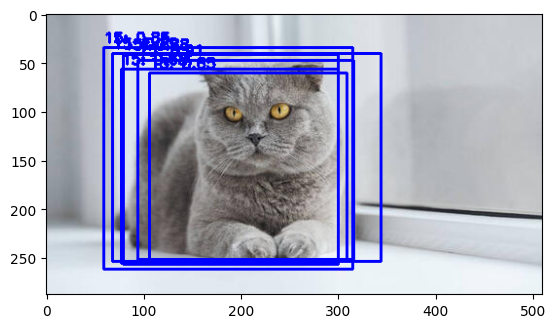

In [43]:
import cv2
import matplotlib.pyplot as plt

net = cv2.dnn.readNet("cfg/yolov3.cfg", "/content/yolov3.weights")


def predict_image(image_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


    outs = net.forward(output_layers)

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                print(f"Class ID: {class_id}, Confidence: {confidence:.2f}")

                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
                text = f'{class_id}: {confidence:.2f}'
                cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()


image_path = "/content/Scottish Fold.2.jpg"
predict_image(image_path)

In [44]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from util import *
import darknet

from __future__ import division
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from util import *
import argparse
import os
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

model = Darknet("cfg/yolov3.cfg")
model.load_state_dict(torch.load("/content/checkpoints/model_checkpoint_epoch_19.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


classes = load_classes("data/coco.names")

transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
])

image_path = "/content/Scottish Fold.2.jpg"
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    detections = model(image_tensor, CUDA=True)

for detection in detections:
    print(f"Detected {len(detection)} objects.")
    for *xyxy, conf, cls_conf, cls_pred in detection:
        print(f"\tObject: {classes[int(cls_pred)]}, Confidence: {cls_conf.item()}")

Streaming output truncated to the last 5000 lines.
	Object: person, Confidence: 0.010772308334708214
	Object: person, Confidence: 0.012070024386048317
	Object: person, Confidence: 0.00829705037176609
	Object: person, Confidence: 0.008804727345705032
	Object: person, Confidence: 0.009651178494095802
	Object: person, Confidence: 0.015261177904903889
	Object: person, Confidence: 0.014114867895841599
	Object: person, Confidence: 0.013282121159136295
	Object: person, Confidence: 0.013471576385200024
	Object: person, Confidence: 0.012146455235779285
	Object: person, Confidence: 0.01242046244442463
	Object: person, Confidence: 0.00934621226042509
	Object: person, Confidence: 0.009603205136954784
	Object: person, Confidence: 0.01106491032987833
	Object: person, Confidence: 0.010305838659405708
	Object: person, Confidence: 0.010642891749739647
	Object: person, Confidence: 0.011870295740664005
	Object: person, Confidence: 0.010012672282755375
	Object: person, Confidence: 0.010304667055606842
	Ob

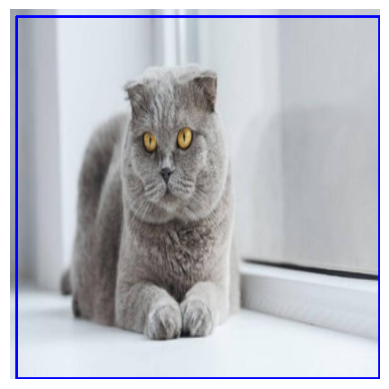

In [45]:

model = Darknet("cfg/yolov3.cfg")
model.load_state_dict(torch.load("/content/checkpoints/model_checkpoint_epoch_15.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

classes = load_classes("data/coco.names")

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
])

image_path = "/content/Scottish Fold.2.jpg"
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    detections = model(image_tensor, CUDA=True)


image_np = np.transpose(image_tensor.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
image_np = np.uint8(image_np * 255)

image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

max_confidence = -1
max_confidence_box = None
max_confidence_label = None
for detection in detections:
    for *xyxy, conf, cls_conf, cls_pred in detection:
        if cls_conf > max_confidence:
            max_confidence = cls_conf
            max_confidence_box = [int(i) for i in xyxy]
            max_confidence_label = classes[int(cls_pred)]

if max_confidence_box is not None:
    cv2.rectangle(image_cv, (max_confidence_box[0], max_confidence_box[1]), (max_confidence_box[2], max_confidence_box[3]), (255, 0, 0), 2)

    class_name = max_confidence_label
    confidence_value = max_confidence.item()
    text_label = f"{class_name} - Confidence: {confidence_value:.2f}"

    text_x = max_confidence_box[0]
    text_y = max_confidence_box[1] - 10

    cv2.putText(image_cv, text_label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()



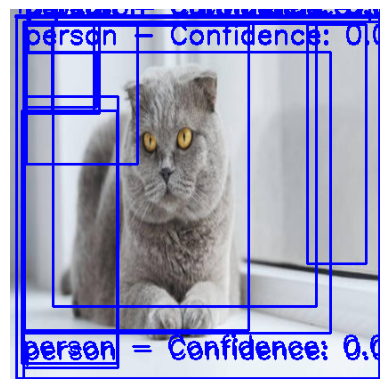

In [46]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from util import *
import darknet

from __future__ import division
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from util import *
import argparse
import os
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

model = Darknet("cfg/yolov3.cfg")
model.load_state_dict(torch.load("/content/checkpoints/model_checkpoint_epoch_15.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

classes = load_classes("data/coco.names")

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
])

image_path = "/content/Scottish Fold.2.jpg"
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    detections = model(image_tensor, CUDA=True)

image_np = np.transpose(image_tensor.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
image_np = np.uint8(image_np * 255)

image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

max_confidence = -1
max_confidence_box = None
max_confidence_label = None
for detection in detections:
    for *xyxy, conf, cls_conf, cls_pred in detection:
        if cls_conf > max_confidence:
            max_confidence = cls_conf
            max_confidence_box = [int(i) for i in xyxy]
            max_confidence_label = classes[int(cls_pred)]
            text_label = f"{max_confidence_label} - Confidence: {max_confidence:.2f}"
            cv2.rectangle(image_cv, (max_confidence_box[0], max_confidence_box[1]), (max_confidence_box[2], max_confidence_box[3]), (255, 0, 0), 2)
            cv2.putText(image_cv, text_label, (max_confidence_box[0], max_confidence_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()